In [1]:
import os
import sys
sys.path.append("../library")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns

import utils
from dataProcess import *
from defaultPlot import *
from stringFormat import *

In [2]:
param = utils.set_default()

In [3]:
net_prefix = utils.network_prefix(param)
DATA_DIR = os.path.join('data', net_prefix)
FIG_DIR = os.path.join('fig', net_prefix)
try:
    os.mkdir(FIG_DIR)
except FileExistsError:
    pass
adj_path = os.path.join(DATA_DIR, "Adjacency.csv")
distance_path = os.path.join(DATA_DIR, "FullDistance.csv")

# Import to networkx

In [4]:
adj = pd.read_csv(adj_path, header=None)
G = nx.from_pandas_adjacency(adj)

## Exclude Isolated nodes

In [27]:
giant_cluster = max(nx.connected_components(G), key=len)
G = G.subgraph(giant_cluster)
print("Size of giant cluster: {}".format(len(list(G))))

Size of giant cluster: 8735


In [5]:
BC = nx.betweenness_centrality(G)
nx.set_node_attributes(G, BC, 'BC')
nx.write_gpickle(G, os.path.join(DATA_DIR, "networkx.pkl"))


# Load network

In [14]:
G = nx.read_gpickle(os.path.join(DATA_DIR, "networkx.pkl"))


## Get cluster coefficent and degree correlation

In [30]:
cluster_coeff = nx.average_clustering(G)
degree_corr = nx.algorithms.assortativity.correlation.degree_assortativity_coefficient(G)

print("Clustering coefficient: {:.4f}".format(cluster_coeff))
print("Degree correlation: {:.4f}".format(degree_corr))

Clustering coefficient: 0.0237
Degree correlation: -0.0490


## Degree distribution

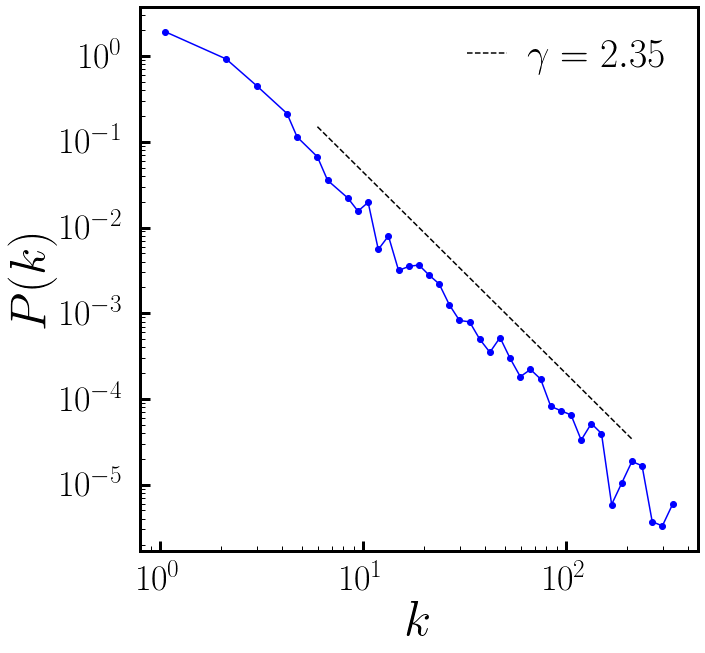

In [5]:
fig, ax = plt.subplots(figsize=(10,10))

dist = np.array(nx.degree_histogram(G))
degree = np.arange(0, len(dist), 1)

degree, dist = distLogBin(degree, dist, max_exponent=3,delta_exponent=0.05)
ax.plot(degree, dist, 'bo-')
fitX, fitY, gamma, _ = logFit(degree[5:-4], dist[5:-4], offset=-0.5)
ax.plot(fitX, fitY, 'k--', label=latex_string("\gamma={:.2f}".format(-gamma)))

ax.legend(loc="best")
ax.set_xlabel(latex_string("k"))
ax.set_ylabel(latex_string("P(k)"))
ax.set_xscale("log")
ax.set_yscale('log')

# fig.savefig(os.path.join(FIG_DIR, "DegreeDistribution.pdf"))
fig.show()

## Betweeness Centrality

In [21]:
BC[999]

0.0006106141667018141

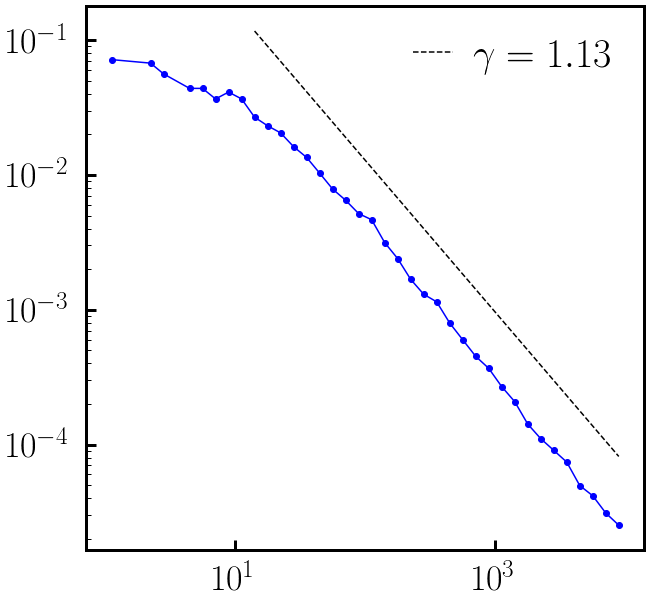

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))

BC = nx.get_node_attributes(G, 'BC')
x, y = avgLogBin(np.array(list(BC.keys())),
                 np.array(list(BC.values())),
                 min_exponent=0,
                 max_exponent=np.log10(param.network_size),
                 delta_exponent=0.1)

ax.plot(x, y, 'bo-')
fitX, fitY, gamma, _ = logFit(x[8:], y[8:], offset=-0.5)
ax.plot(fitX, fitY, 'k--', label=latex_string("\gamma={:.2f}".format(-gamma)))

ax.legend(loc="best")
# ax.set_xlabel(latex_string("k"))
# ax.set_ylabel(latex_string("P(k)"))
ax.set_xscale("log")
ax.set_yscale('log')

fig.show()


# Full distance

In [46]:
#* Read only giant cluster
full_distance = pd.read_csv(distance_path,
                            usecols=list(G),
                            skiprows=set(range(param.network_size)) - set(G),
                            header=None)
full_distance

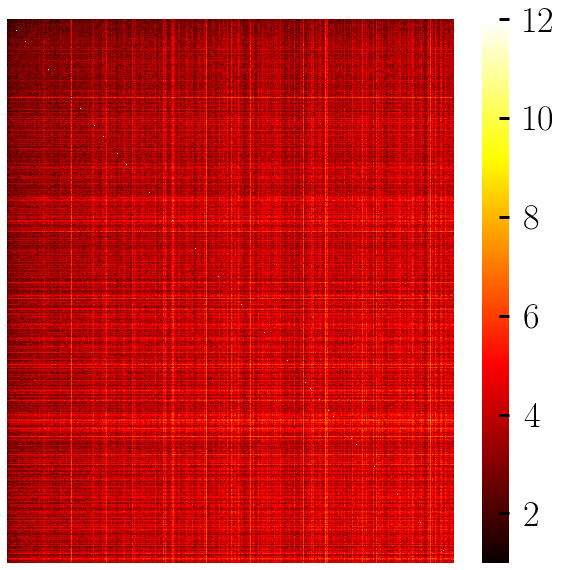

In [55]:
fig, ax = plt.subplots()

sns.heatmap(full_distance, cmap='hot', ax=ax, mask=np.eye(len(full_distance.values[0])))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(length=0)

fig.savefig(os.path.join(FIG_DIR, "FullDistance.png"))
fig.show()